# From NIR to SPECK

In this notebook we will show how a NIR model can be deployed onto SynSense's Speck processor. 

We start by importing the model into sinabs and from there deploy it onto Speck. We will test the deployed model by streaming events onto the chip and reading out the predictions.

In [1]:
# Import statements
from matplotlib import pyplot as plt
import matplotlib as mpl
import nir
import numpy as np
import sinabs
from sinabs.backend.dynapcnn import DynapcnnNetwork
from sinabs.backend.dynapcnn.chip_factory import ChipFactory
from statistics import mode
import tonic
import torch
from tqdm.notebook import tqdm

# Matplotlib settings
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 20

## Load NIR model from disk

In [2]:
model_path = "scnn_mnist.nir"
nir_model = nir.read(model_path)

## Load NIR model into sinabs

Loading a NIR model into sinabs is fairly easy: It's literally one line of code.

In [3]:
sinabs_model = sinabs.from_nir(nir_model, batch_size=1).cuda()

### Test the model in software

Let's quickly run the test set through the sinabs model to make sure everything works as it should.

In [4]:
# Convert events to frames for software simulation
to_frame = tonic.transforms.ToFrame(
    sensor_size=tonic.datasets.NMNIST.sensor_size, time_window=1e3
)
frame_dataset = tonic.datasets.NMNIST(".", train=False, transform=to_frame)
# Only use every 200th sample
indices = torch.arange(50) * 200
subset = torch.utils.data.Subset(frame_dataset, indices)

correct = 0
for (sample, target) in tqdm(subset, total=len(subset)):
    # sample = sample.flatten(0,1)
    output = sinabs_model(torch.from_numpy(sample).to("cuda", dtype=torch.float))
    # output = output.reshape((32, -1, *output.shape[1:]))
    prediction = torch.argmax(output.sum(0)).cpu()
    correct += (prediction == target)

accuracy = correct / len(subset)
print(f"Test accuracy with sinabs model: {accuracy:.2%}")

  0%|          | 0/50 [00:00<?, ?it/s]

Test accuracy with sinabs model: 96.00%


## Deploy the model onto Speck

Deploying a model onto Speck with Sinabs is also straightforward:

### Prepare model and deploy

In [5]:
# - Prepare model
# Convert model to sequential
sequential_model = torch.nn.Sequential(
    *(node.elem for node in sinabs_model.execution_order)
).cpu()

# Speck does not support individual parameters per neuron.
# Set threshold to a single value per spiking layer
for mod in sequential_model:
    if isinstance(mod, sinabs.layers.IAF):
        # Choose threshold to be the same for all neurons
        mod.spike_threshold = torch.nn.Parameter(
            torch.tensor([mod.spike_threshold.flatten()[0]])
        )
        mod.min_v_mem = torch.nn.Parameter(torch.tensor([mod.min_v_mem.flatten()[0]]))

# - Actual deployment
speck_model = DynapcnnNetwork(sequential_model, input_shape=(2,34,34))
speck_model.to("speck2fmodule", monitor_layers=[-1]);

Network is valid


### Prepare dataset
For the software simulation in sinabs we converted the input data to frames. For Speck, we can send the events directly as they are.

In [6]:
# This time don't convert data to frames
event_dataset = tonic.datasets.NMNIST(".", train=False)
event_subset = torch.utils.data.Subset(event_dataset, indices)

# The chip factory will help us convert the structured array data to events for Speck
chip_factory = ChipFactory("speck2fmodule")
layer_in = speck_model.chip_layers_ordering[0]




### Some helper functions

In [7]:
# This will help us choose samples of a given target
targets = np.array(event_dataset.targets)
target_indices = {idx: np.where(targets == idx)[0] for idx in range(10)}

def plot_hist(output, target):
    # Extract features from output events and take most prevalent as prediction
    features = [event.feature for event in output]
    prediction = mode(features)
    
    # Draw histogram
    fig, ax = plt.subplots()
    bins = np.arange(11)-0.5
    N, bins, patches = ax.hist(features, bins=bins, edgecolor='white', linewidth=1)
    plt.title(f"Prediction: {prediction} ({f'target: {target}' if target!=prediction else 'correct'})")
    plt.ylabel("Event count")
    plt.xlabel("Feature")
    plt.xticks(np.arange(10));
    
    # Set bar colors according to prediction and target
    for i, patch in enumerate(patches):
        if i == prediction and i == target:
            patch.set_facecolor('g')
        elif i == prediction:
            patch.set_facecolor('r')
        elif i == target:
            patch.set_facecolor('k')
            
    # Make xtick label of prediciton bold
    ax.xaxis.get_major_ticks()[prediction].label1.set_fontweight("bold")
            
    return prediction

def test_sample(target):
    index = np.random.choice(target_indices[target])
    sample, tgt = event_dataset[index]
    assert(target == tgt)
    image = to_frame(sample).sum((0, 1))
    plt.imshow(image)
    plt.title("Input")
    
    # Convert data to speck events and send it to the chip
    input_events = chip_factory.xytp_to_events(sample, layer=layer_in, reset_timestamps=True)
    output = speck_model(input_events)
    
    prediction = plot_hist(output, target)
    print(f"Speck prediction: {prediction}")

## Live demo

Now that the model has been deployed onto Speck and the data has been prepared, let's see if it works.

Speck prediction: 8


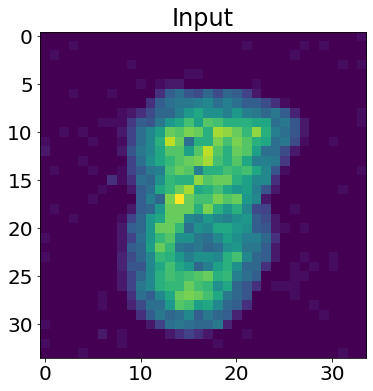

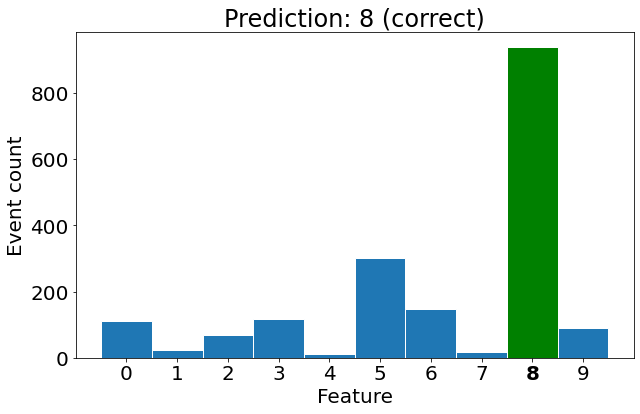

In [8]:
test_sample(8)

## Send test data to the chip and read out its prediction
To get some quantitative idea about how well the on-chip model does, we can use the test data from above and run it through the chip.

In [9]:
correct = 0
predictions = []
for (sample, target) in tqdm(event_subset, total=len(event_subset)):
    input_events = chip_factory.xytp_to_events(sample, layer=layer_in, reset_timestamps=True)
    output = speck_model(input_events)
    prediction = mode((event.feature for event in output)) if output else -1
    correct += (prediction == target)
    predictions.append(prediction)

accuracy = correct / len(subset)
print(f"Test accuracy on speck: {accuracy:.2%}")

  0%|          | 0/50 [00:00<?, ?it/s]

Test accuracy on speck: 90.00%
